# Noisy handwriting, deep learning and auto-encoders



In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('white')
sns.set_context('poster')

In [9]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original", data_home='./data/')  

X, y = mnist.data / 255., mnist.target

print("Dimensions of X:", X.shape)
print("Dimensions of y:", y.shape)

Dimensions of X: (70000, 784)
Dimensions of y: (70000,)


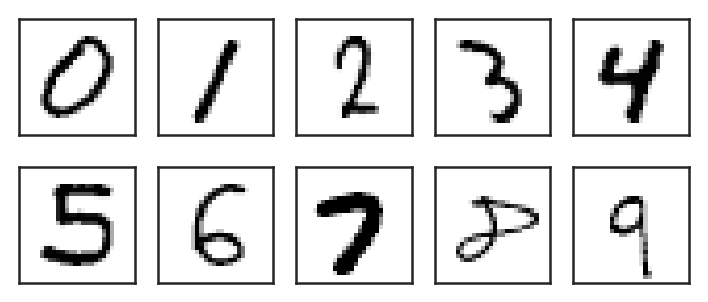

In [5]:
# As you can see, the 70k images have 784 pixels, which is 28**2, and that's not a coincidence:
imsize = 28

# Look at a random example of every number. Run the cell several times to see several examples. 
plt.figure(figsize=(12, 5)
for target in range(10):
    thisone = np.random.choice(np.where(y == target)[0])
    number = np.reshape(np.array(X[thisone]), [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

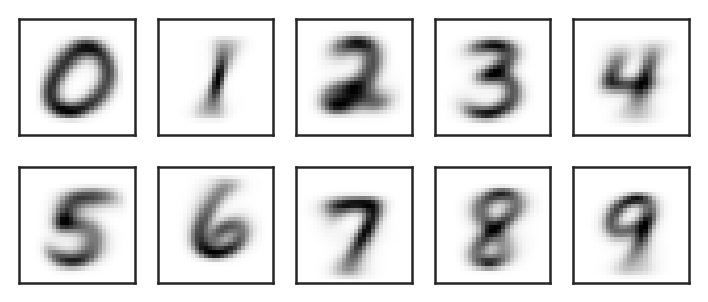

In [6]:
# We can also generate the mean image for every digit.
# This in fact comes close to the model we are going to train!
plt.figure(figsize=(12, 5)
for target in range(10):
    number = np.reshape( X[np.where(y==target)].mean(axis=0) , [imsize, imsize])
    pp = plt.subplot(2, 5, target+1)
    pp.imshow(number, interpolation='nearest', cmap='Greys')
    pp.set_xticklabels([])
    pp.set_yticklabels([])

In [10]:
# A rename for clarity
labels = y
features = X

In [14]:
# Import machine learning functionality used here.
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Splitting training and test data, and initialize a LogisticRegression with default settings.
xtr, x, ytr, y = train_test_split(features, labels, test_size=0.3)
clf = LogisticRegression()

# Perform the logistic regression and evaluate results.
clf.fit(xtr, ytr)
print("Score on training set: {0:3.2f} \nScore on independent test data: {1:3.2f}".format(clf.score(xtr, ytr), clf.score(x, y)))

Score on training set: 0.93 
Score on independent test data: 0.92


/home/marcel/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.


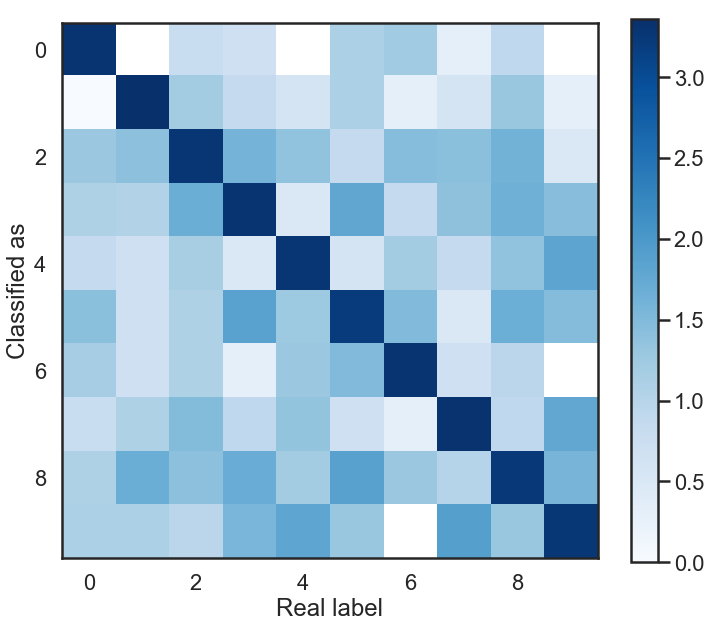

In [15]:
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(12, 10))
plt.imshow(np.log10(confusion_matrix(y, clf.predict(x))), interpolation='nearest', cmap='Blues')
plt.xlabel("Real label")
plt.ylabel("Classified as")
plt.colorbar();

In [18]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()

mlp.fit(xtr, ytr)
print("Score on independent test data: {0:5.4f}".format(mlp.score(x, y)))

Score on independent test data: 0.9761


In [22]:
mlp_deep = MLPClassifier(hidden_layer_sizes=(500, 200, 50))

mlp_deep.fit(xtr, ytr)
print("Score on independent test data: {0:5.4f}".format(mlp_deep.score(x, y)))

Score on independent test data: 0.9793


In [27]:
import tensorflow as tf
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(500, activation=tf.nn.relu),
  tf.keras.layers.Dense(200, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(xtr, ytr, epochs=20)

print("Score on training set: {0:5.4f} \nScore on independent test data: {1:5.4f}".format(model.evaluate(xtr, ytr)[1], model.evaluate(x, y)[1]))

Epoch 1/20
49000/49000 [==============================] - 12s 250us/step - loss: 0.2126 - acc: 0.9348
Epoch 2/20
49000/49000 [==============================] - 12s 247us/step - loss: 0.0909 - acc: 0.9721
Epoch 3/20
49000/49000 [==============================] - 12s 252us/step - loss: 0.0655 - acc: 0.9796
Epoch 4/20
49000/49000 [==============================] - 13s 259us/step - loss: 0.0485 - acc: 0.9842
Epoch 5/20
49000/49000 [==============================] - 13s 262us/step - loss: 0.0393 - acc: 0.9879
Epoch 6/20
49000/49000 [==============================] - 13s 261us/step - loss: 0.0320 - acc: 0.9901
Epoch 7/20
49000/49000 [==============================] - 13s 260us/step - loss: 0.0261 - acc: 0.9920
Epoch 8/20
49000/49000 [==============================] - 13s 267us/step - loss: 0.0263 - acc: 0.9917
Epoch 9/20
49000/49000 [==============================] - 14s 294us/step - loss: 0.0203 - acc: 0.9937
Epoch 10/20
49000/49000 [==============================] - 14s 295us/step - loss: 